<font size="6">LSTM Stock Price Predictor</font>

This is a model which fits a dataset for Apple with a long short-term memory network.

In [126]:
import math
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [127]:
#importing the dataframe
df = pd.read_csv("C:/Users/abdel/Downloads/HistoricalData_1738961368129.csv")
prices = df["Close/Last"]
new_prices=[]

#allowing the data to be readable
for i in range(len(prices)):
    #prices[i]=float(prices[i][1:])
    new_prices.append(float(prices[i][1:]))


#min-max scaling
min_value = min(new_prices)
max_value = max(new_prices)
i=0
for p in new_prices:
    new_prices[i]=(p-min_value)/(max_value-min_value) 

train_data = new_prices[:180]
test_data = new_prices[180:]


#print(prices)"""

<font size = "2">Let's create a function that creates sequences and returns the sequence and target as it will be fundamental in training the data</font>

In [128]:
def create_seq(seq, n):
    """Returns a pair of the 2x2 dimensional array of sequences and the respective target for each sequence"""

    sequences, targets = [], []
    for i in range(len(seq)-n):
        sequences.append(seq[i:i+n])
        targets.append(seq[i+n])
    return np.array(sequences), np.array(targets, dtype=float)

seq_length = 15
train_seq = create_seq(train_data, seq_length)

<font size ="5">Long Short-Term Memory Network Architecture</font>

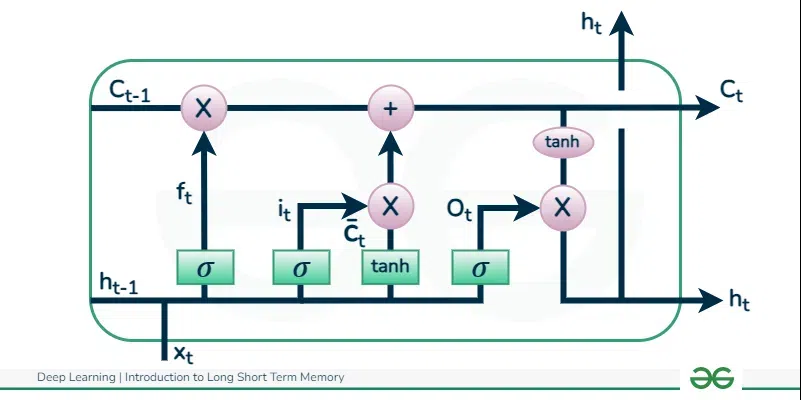

<font size ="2">
A long-short term memory network is an improved version of a recuurent neural network which has a better handling of long term memory as it prevents the gradient vanishing/explosion problem. It does so by storing a long term memory and a short term memory. 

The LSTM architectures involves the memory cell which is controlled by three gates: the input gate, the forget gate, and the output gate. These gates decide what information to add to, remove from, and output from the memory cell.

* The input gate controls what information is added to the memory cell. (i<sub>t</sub>)
* The forget gate controls what information is removed from the memory cell. (f<sub>t</sub>)
* The output gate controls what information is output from the memory cell. (O<sub>t</sub>)

This allows LSTM networks to selectively retain or discard information as it flows through the network, which allows them to learn long-term dependencies.

The LSTM maintains a hidden state, which acts as the short-term memory of the network. The hidden state is updated based on the input, the previous hidden state, and the memory cell’s current state.
</font>


In [129]:
#Implementing long-term memory (Cell State) and a short-term memory (Hidden state)
num_layers = 1
batch_size = 166
hidden_size = 15

#cell_state = torch.zeros(num_layers, batch_size, hidden_size)
#hidden_state = torch.zeros(num_layers, batch_size, hidden_size)
cell_state = 0

hidden_state = 0

<font size = "4">The Forget Gate</font>

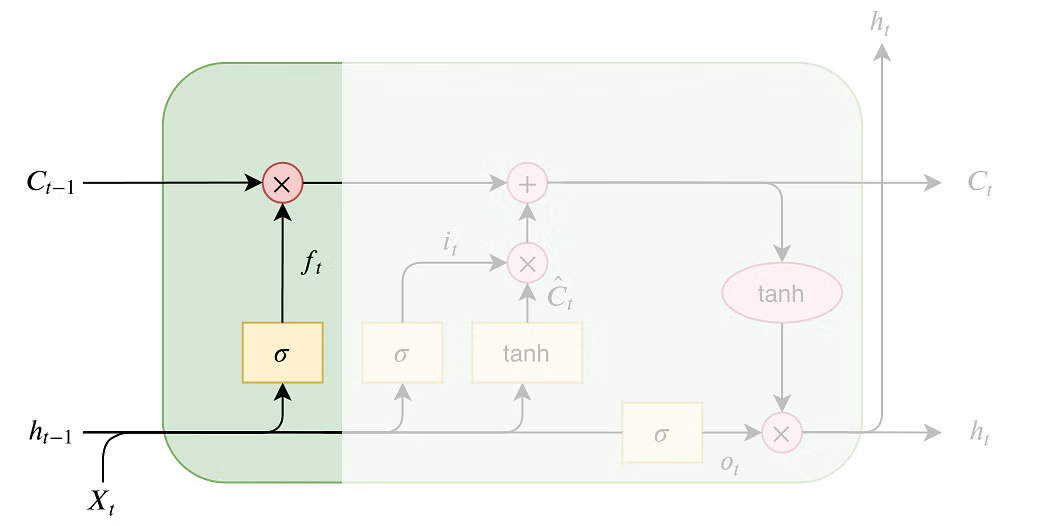

<font size = "2">
Based on the previous data and the input data this gate determines which elements in the long-term memory are relevant and takes the previous hidden state h<sub>t-1</sub> and the new input data X<sub>t</sub> as inputs and outputs a vector where the values are between 0 and 1 where values closer to 0 are forgotten and values close to 1 are remembered and are multiplied in the Cell state (Long-term memory).</font>

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$ 

$$f_t = \sigma(W_f\cdot[h_{t-1},X_{t}]+b_f)$$
<font size = "2">Where W<sub>f</sub> is the weight of the forget gate and b<sub>f</sub> is the bias of the forget gate.</font>


In [130]:
Wf = torch.tensor([np.random.normal(loc=0,scale=1)], dtype=torch.float32, requires_grad=True) #generates random number from gausian distribution
bf = torch.tensor([1.0], dtype=torch.float32, requires_grad=True) #forget bias initialised at 1

def sigmoid(x):
    return (1/ (1+(math.exp(-x))))

def forget_gate(hidden, input):
    return sigmoid((Wf*hidden + bf)+(Wf*input + bf))

<font size ="4">The Input gate</font>

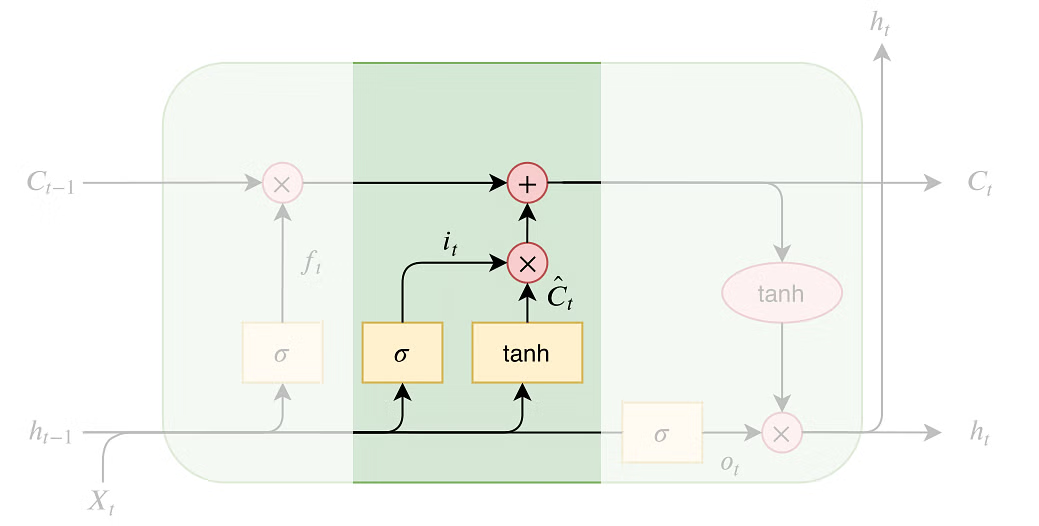
<font size = "2">
The additional useful information is managed through the input gate. There are two neural networks working in this gate, the input network and the new memory network. The weights and the biases W<sub>i</sub> and b<sub>i</sub> are applied with the sigmoid function and then multiplied with the other network with the weights and biases W<sub>c</sub> and b<sub>c</sub> with tanh activation function and are added to the cell state/ long-term memory.

The input gate serves as a filter to identify the valuable components of the new memory vector and acts as a filter to the cell state. Low output values from the input gate means that the corresponding element of the cell state should not be updated
</font>
$$i_t = \sigma(W_i\cdot[h_{t-1},X_t]+b_i)$$
<font size = "2">
The new memory network combines the previous hidden state and the current input data and after applying the tanh activation function it determines how much of the cell state is updated. tanh is used as its values lie between [-1,1] so its ability to produce negative values is essential.
</font>

$$tanh(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

$$\hat{C}_t=tanh(W_c\cdot[h_{t-1},X_t]+b_c) $$

Overall the cell state is updated through the network by:
$$C_t = i_t\cdot \hat{C}_t + f_t\cdot C_{t-1}$$

In [131]:
Wi = torch.tensor([np.random.normal(loc=0,scale=1)], requires_grad=True, dtype=torch.float32)
bi = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)

def input_gate(hidden,input):
    return sigmoid((Wi*hidden + bi)+(Wi*input +bi))

Wc = torch.tensor([np.random.normal(loc=0,scale=1)], dtype=torch.float32, requires_grad=True)
bc = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)

def new_memory_gate(hidden, input):
    return math.tanh((Wc*hidden + bc)+(Wc*input + bc))

def updated_cell_state(hidden, input):
    return(input_gate(hidden, input)*new_memory_gate(hidden,input) + forget_gate(hidden,input)*cell_state)

<font size = "4">The Output Gate</font>

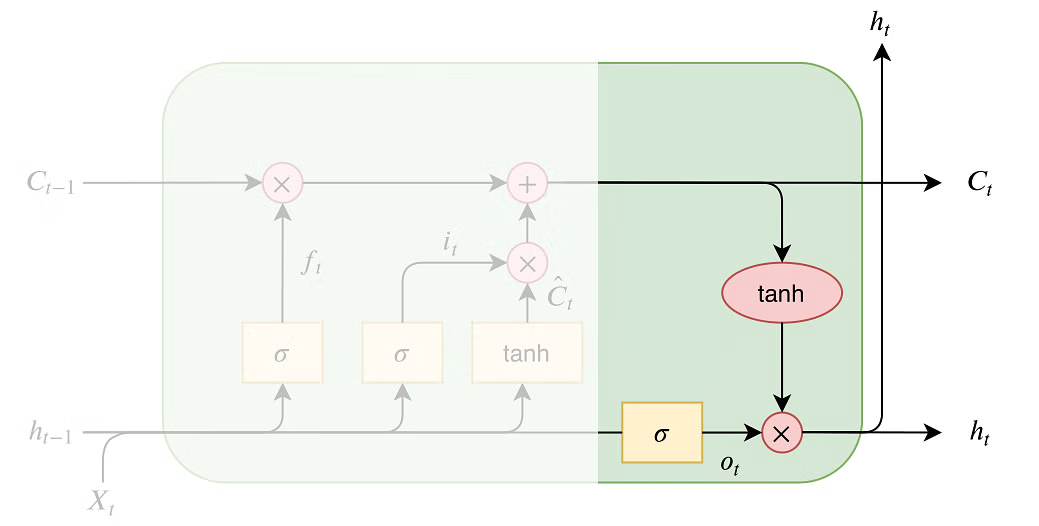

<font size ="2">
This gate is to produce the next hidden state (the short-term memory) or the output if there are no more hidden states to be passed on. This stage uses the updated cell state, input data and previous hidden state to produce an output. First it applies the sigmoid function to the hidden state-input pair with the weights and biases (W<sub>o</sub> and b<sub>o</sub>) applied, then it multiplies it with the tanh of the new cell-state to produce an output h<sub>t</sub>.</font>

$$o_t = \sigma(W_o\cdot[h_{t-1},X_t]+b_o)$$

$$h_t = o_t \times tanh(C_t)$$

In [132]:
Wo = torch.tensor([np.random.normal(loc=0,scale=1)], dtype=torch.float32, requires_grad=True)
bo = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)

def output_gate(hidden,input):
    return sigmoid((Wo*hidden + bo)+(Wo*input + bo))

def updated_hidden(hidden,input):
    return(output_gate(hidden,input) * math.tanh(cell_state))

<font size ="4">Finding the weights and biases</font>

<font size = "3">
1. Defining the Loss function</font>


<font size = "2">First step is to define a loss function. This will tell us how accurate the model is to the data it is training. We can use MSE (Mean Squared Error) as a good loss function as it is easy to use and effective for regression. 

$$MSE=\frac{1}{n}\sum_{i=1}^{n} (y_i-\hat{y}_i)^2$$
</font>

<font size = "3">
2.Initialising the weights and biases</font>

<font size = "2">The weights are initialised using a random gaussian distribution which typically results in small random values.

The biases are initialised to 0 except for b<sub>f</sub> which is initialised to 1 to prevent vanishing gradients.</font>

<font size = "3">
3.Updating the weights and biases</font>

<font size = "2"> We run the values through the network with the initiaised variables then we compute the loss using the loss function (MSE in this case). Then wew use, backpropogation by computing the gradients with respect to each parameter via chain rule and adjust the gradients considering the time dependency. Then we update the parameters using gradient descent with the equation.
</font>

$$\theta = \theta - \eta \cdot \frac{\delta L}{\delta \theta}$$
,
<font size = "2">
where $\eta$ is the learning rate and $\frac{\delta L}{\delta \theta}$ is the gradient of the loss function.

After running it through this process a few times the parameters should converge to become accurate to the model.

Note: We can use truncated backpropogation to save space but it could lead to long-term memory loss.</font>

Creating the model to find the weights

In [133]:
def MSE(predicted, actual):
    n=len(predicted)
    return (sum(actual-predicted)**2)/n

eta = 0.01  #learning rate

def LSTM_predict(data, number=1):
    output=[]
    cell_state = 0
    hidden_state = 0
    for input in data:
        cell_state = updated_cell_state(hidden_state, input)
        hidden_state= updated_hidden(hidden_state, input)
    for i in range(number):
        output.append(hidden_state)
        cell_state = updated_cell_state(hidden_state, hidden_state)
        hidden_state = updated_hidden(hidden_state, hidden_state)
    return output

parameters = [Wf, bf, Wi, bi, Wc, bc, Wo, bo]
optimiser = optim.Adam(parameters, eta)
critereon = nn.MSELoss()

def LSTM_fit(data, seq_length=10, epochs=1000):
    train_seq, train_targets = create_seq(data, seq_length)
    for j in range(epochs):
        train_predicted = []
        for i in range(len(train_targets)):
            train_predicted.append(LSTM_predict(train_seq[i])[0])
        
        train_targets = torch.tensor(train_targets, dtype=torch.float32)
        train_predicted = torch.tensor(train_predicted, dtype=torch.float32)

        loss = critereon(train_predicted, train_targets)
        loss.backward()
        optimiser.step()

LSTM_fit(train_data)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn